<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sklearn Tuner for CNN Activity Classifier - V3

In this notebook, we use SKlearn  to tune a CNN neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sklearn
# bug in sklearn wrapper
#https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if sklearn.__version__ != '0.21.2':
    print("updating sklearn ...")
    !pip install --user scikit-learn==0.21.2
    


ModuleNotFoundError: No module named 'tensorflow'

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/tune-cnn-lstm'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [5]:
# sklearn hyperparams
params = {
    
    # Conv layers
    'n_conv_1':[512, 768], # filters, a.k.a. kernels
    'k_conv_1':[2, 3], # kernel length
    'n_conv_2':[256, 512], # filters, a.k.a. kernels
    'k_conv_2':[2, 3], # kernel length
    'n_conv_3':[256, 512], # filters, a.k.a. kernels
    'k_conv_3':[2, 3], # kernel length
    'maxpooling_pool_size':[2, 3],
    'avepooling_pool_size':[2, 3],
    
    # LSTM layers
    'n_lstm_1' : [128, 256],
    'n_lstm_2' : [128, 256],
    'drop_lstm_1' : [0.02,0.1],
    'drop_lstm_2' : [0.02,0.1],

    
    # Dense layers
    'n_dense_1':[256, 384, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 384, 512],
    'dropout_2':[0.2, 0.3],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 256


NameError: name 'LeakyReLU' is not defined

#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [5]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [6]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [7]:
y = to_categorical(labels_array_int, num_classes=n_class)

### Splitting and shuffeling the data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [6]:
params

NameError: name 'params' is not defined

In [10]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_lstm_1=128, n_lstm_2=128,
                 drop_lstm_1=0.02,drop_lstm_2=0.02, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    # Conv layers
    model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
    model.add(GlobalAveragePooling1D())

    # LSTM layers
    model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True)) 
    model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    print(f"""n_conv_1 = {n_conv_1}, k_conv_1 = {k_conv_1},  n_conv_2 = {n_conv_2}, k_conv_2 = {k_conv_2}, 
          n_conv_3 = {n_conv_3},  k_conv_3 = {k_conv_3},  maxpooling_pool_size = {maxpooling_pool_size},
          avepooling_pool_size = {avepooling_pool_size},
          n_lstm_1 = {n_lstm_1}, n_lstm_2 = {n_lstm_2},
          drop_lstm_1 = {drop_lstm_1}, drop_lstm_2 = {drop_lstm_2},
          n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [11]:
model_default = create_model()
model_default.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 256)           196864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [12]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [13]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 256)           262400    
_________________________________________________________________
average_pooling1d_1 (Average (None, 9, 256)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 512)            393728    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

152/152 [==============================] - 4s 24ms/step - loss: 0.0954 - accuracy: 0.9639
Epoch 58/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1007 - accuracy: 0.9618
Epoch 59/60
152/152 [==============================] - 4s 24ms/step - loss: 0.0994 - accuracy: 0.9633
Epoch 60/60
76/76 [==============================] - 1s 10ms/step - loss: 0.2855 - accuracy: 0.9349
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 29, 512)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 28, 256)           262400    
_________________________________________________________________
average_pooling1d_3 (Average (None, 9, 256)            0

152/152 [==============================] - 4s 24ms/step - loss: 0.0979 - accuracy: 0.9627
Epoch 56/60
152/152 [==============================] - 4s 24ms/step - loss: 0.0984 - accuracy: 0.9629
Epoch 57/60
152/152 [==============================] - 4s 24ms/step - loss: 0.0956 - accuracy: 0.9631
Epoch 58/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1040 - accuracy: 0.9605
Epoch 59/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1065 - accuracy: 0.9603
Epoch 60/60
76/76 [==============================] - 1s 10ms/step - loss: 0.2669 - accuracy: 0.9292
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 88, 768)           7680      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 44, 768)           0         
__________________________________________________

Epoch 54/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2362 - accuracy: 0.9082
Epoch 55/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2336 - accuracy: 0.9094
Epoch 56/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2339 - accuracy: 0.9084
Epoch 57/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2344 - accuracy: 0.9106
Epoch 58/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2341 - accuracy: 0.9093
Epoch 59/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2242 - accuracy: 0.9134
Epoch 60/60
76/76 [==============================] - 1s 18ms/step - loss: 0.2432 - accuracy: 0.9094
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 88, 768)           7680      
_________________________________________________________________
ma

Epoch 51/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2531 - accuracy: 0.9014
Epoch 52/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2489 - accuracy: 0.9031
Epoch 53/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2418 - accuracy: 0.9054
Epoch 54/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2494 - accuracy: 0.9053
Epoch 55/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2416 - accuracy: 0.9062
Epoch 56/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2330 - accuracy: 0.9110
Epoch 57/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2304 - accuracy: 0.9097
Epoch 58/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2377 - accuracy: 0.9068
Epoch 59/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2283 - accuracy: 0.9122
Epoch 60/60
76/76 [==============================] - 1s 17ms/step - loss: 0.2671 -

152/152 [==============================] - 10s 67ms/step - loss: 0.2413 - accuracy: 0.9075
Epoch 46/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2340 - accuracy: 0.9082
Epoch 47/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2309 - accuracy: 0.9099
Epoch 48/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2410 - accuracy: 0.9060
Epoch 49/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2390 - accuracy: 0.9075
Epoch 50/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2304 - accuracy: 0.9098
Epoch 51/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2310 - accuracy: 0.9110
Epoch 52/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2282 - accuracy: 0.9096
Epoch 53/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2253 - accuracy: 0.9103
Epoch 54/60
152/152 [==============================] - 10s 67ms/step - loss: 0.2264 -

152/152 [==============================] - 6s 40ms/step - loss: 0.2838 - accuracy: 0.8894
Epoch 41/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2771 - accuracy: 0.8926
Epoch 42/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2829 - accuracy: 0.8881
Epoch 43/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2757 - accuracy: 0.8920
Epoch 44/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2670 - accuracy: 0.8956
Epoch 45/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2671 - accuracy: 0.8966
Epoch 46/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2614 - accuracy: 0.8974
Epoch 47/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2548 - accuracy: 0.9012
Epoch 48/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2545 - accuracy: 0.9020
Epoch 49/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2417 - accuracy:

152/152 [==============================] - 6s 40ms/step - loss: 0.3168 - accuracy: 0.8776
Epoch 35/60
152/152 [==============================] - 6s 40ms/step - loss: 0.3161 - accuracy: 0.8778
Epoch 36/60
152/152 [==============================] - 6s 40ms/step - loss: 0.3095 - accuracy: 0.8793
Epoch 37/60
152/152 [==============================] - 6s 40ms/step - loss: 0.3004 - accuracy: 0.8836
Epoch 38/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2860 - accuracy: 0.8872
Epoch 39/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2938 - accuracy: 0.8853
Epoch 40/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2909 - accuracy: 0.8867
Epoch 41/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2760 - accuracy: 0.8917
Epoch 42/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2793 - accuracy: 0.8914
Epoch 43/60
152/152 [==============================] - 6s 40ms/step - loss: 0.2677 - accuracy:

152/152 [==============================] - 4s 24ms/step - loss: 0.1802 - accuracy: 0.9348
Epoch 31/60
152/152 [==============================] - 4s 23ms/step - loss: 0.1844 - accuracy: 0.9311
Epoch 32/60
152/152 [==============================] - 4s 23ms/step - loss: 0.1728 - accuracy: 0.9371
Epoch 33/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1678 - accuracy: 0.9382
Epoch 34/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1731 - accuracy: 0.9354
Epoch 35/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1694 - accuracy: 0.9381
Epoch 36/60
152/152 [==============================] - 4s 23ms/step - loss: 0.1655 - accuracy: 0.9381
Epoch 37/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1589 - accuracy: 0.9412
Epoch 38/60
152/152 [==============================] - 4s 24ms/step - loss: 0.1583 - accuracy: 0.9421
Epoch 39/60
152/152 [==============================] - 4s 23ms/step - loss: 0.1576 - accuracy:

152/152 [==============================] - 5s 30ms/step - loss: 0.3880 - accuracy: 0.8479
Epoch 27/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3902 - accuracy: 0.8491
Epoch 28/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3757 - accuracy: 0.8544
Epoch 29/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3705 - accuracy: 0.8571
Epoch 30/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3703 - accuracy: 0.8583
Epoch 31/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3627 - accuracy: 0.8600
Epoch 32/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3500 - accuracy: 0.8645
Epoch 33/60
152/152 [==============================] - 4s 30ms/step - loss: 0.3466 - accuracy: 0.8663
Epoch 34/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3464 - accuracy: 0.8670
Epoch 35/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3284 - accuracy:

152/152 [==============================] - 5s 30ms/step - loss: 0.4502 - accuracy: 0.8224
Epoch 23/60
152/152 [==============================] - 5s 30ms/step - loss: 0.4322 - accuracy: 0.8326
Epoch 24/60
152/152 [==============================] - 5s 30ms/step - loss: 0.4203 - accuracy: 0.8375
Epoch 25/60
152/152 [==============================] - 5s 30ms/step - loss: 0.4081 - accuracy: 0.8408
Epoch 26/60
152/152 [==============================] - 5s 30ms/step - loss: 0.4009 - accuracy: 0.8421
Epoch 27/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3866 - accuracy: 0.8507
Epoch 28/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3862 - accuracy: 0.8489
Epoch 29/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3775 - accuracy: 0.8531
Epoch 30/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3743 - accuracy: 0.8544
Epoch 31/60
152/152 [==============================] - 5s 30ms/step - loss: 0.3640 - accuracy:

152/152 [==============================] - 6s 39ms/step - loss: 0.2239 - accuracy: 0.9157
Epoch 19/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2180 - accuracy: 0.9194
Epoch 20/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2115 - accuracy: 0.9212
Epoch 21/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2093 - accuracy: 0.9216
Epoch 22/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1984 - accuracy: 0.9267
Epoch 23/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1991 - accuracy: 0.9259
Epoch 24/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1971 - accuracy: 0.9247
Epoch 25/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1897 - accuracy: 0.9275
Epoch 26/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1828 - accuracy: 0.9320
Epoch 27/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1789 - accuracy:

152/152 [==============================] - 6s 39ms/step - loss: 0.2291 - accuracy: 0.9147
Epoch 17/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2265 - accuracy: 0.9163 0s - loss: 0.2252 - accuracy
Epoch 18/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2125 - accuracy: 0.9220
Epoch 19/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2083 - accuracy: 0.9235
Epoch 20/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2046 - accuracy: 0.9238
Epoch 21/60
152/152 [==============================] - 6s 39ms/step - loss: 0.2205 - accuracy: 0.9180
Epoch 22/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1929 - accuracy: 0.9287
Epoch 23/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1880 - accuracy: 0.9311
Epoch 24/60
152/152 [==============================] - 6s 39ms/step - loss: 0.1872 - accuracy: 0.9305
Epoch 25/60
152/152 [==============================] - 6s 39ms/st

152/152 [==============================] - 5s 32ms/step - loss: 0.6214 - accuracy: 0.7520 0s - loss: 0.6229 - accura
Epoch 13/60
152/152 [==============================] - 5s 32ms/step - loss: 0.6014 - accuracy: 0.7607
Epoch 14/60
152/152 [==============================] - 5s 32ms/step - loss: 0.5638 - accuracy: 0.7754
Epoch 15/60
152/152 [==============================] - 5s 32ms/step - loss: 0.5377 - accuracy: 0.7901
Epoch 16/60
152/152 [==============================] - 5s 32ms/step - loss: 0.5050 - accuracy: 0.7995
Epoch 17/60
152/152 [==============================] - 5s 32ms/step - loss: 0.4807 - accuracy: 0.8122
Epoch 18/60
152/152 [==============================] - 5s 32ms/step - loss: 0.4596 - accuracy: 0.8225
Epoch 19/60
152/152 [==============================] - 5s 32ms/step - loss: 0.4402 - accuracy: 0.8276
Epoch 20/60
152/152 [==============================] - 5s 32ms/step - loss: 0.4276 - accuracy: 0.8336
Epoch 21/60
152/152 [==============================] - 5s 32ms/step

152/152 [==============================] - 7s 45ms/step - loss: 0.3003 - accuracy: 0.8896
Epoch 9/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2765 - accuracy: 0.8971
Epoch 10/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2598 - accuracy: 0.9025
Epoch 11/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2580 - accuracy: 0.9027
Epoch 12/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2563 - accuracy: 0.9046
Epoch 13/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2452 - accuracy: 0.9081
Epoch 14/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2274 - accuracy: 0.9145
Epoch 15/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2258 - accuracy: 0.9149
Epoch 16/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2255 - accuracy: 0.9160
Epoch 17/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2117 - accuracy: 

152/152 [==============================] - 7s 45ms/step - loss: 0.3794 - accuracy: 0.8600
Epoch 5/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3505 - accuracy: 0.8705
Epoch 6/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3298 - accuracy: 0.8781
Epoch 7/60
152/152 [==============================] - 7s 45ms/step - loss: 0.3064 - accuracy: 0.8853
Epoch 8/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2962 - accuracy: 0.8901
Epoch 9/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2847 - accuracy: 0.8950
Epoch 10/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2546 - accuracy: 0.9070
Epoch 11/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2582 - accuracy: 0.9051
Epoch 12/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2415 - accuracy: 0.9103
Epoch 13/60
152/152 [==============================] - 7s 45ms/step - loss: 0.2382 - accuracy: 0.91

152/152 [==============================] - 7s 48ms/step - loss: 1.2254 - accuracy: 0.4785
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0992 - accuracy: 0.5292
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0417 - accuracy: 0.5519
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.9762 - accuracy: 0.5853
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.8972 - accuracy: 0.6241
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.8097 - accuracy: 0.6621
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.7310 - accuracy: 0.6988
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6637 - accuracy: 0.7273
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6154 - accuracy: 0.7514
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.5764 - accuracy: 0.7672


Epoch 1/60
152/152 [==============================] - 7s 48ms/step - loss: 1.2103 - accuracy: 0.4868
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0997 - accuracy: 0.5284
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0429 - accuracy: 0.5533
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.9833 - accuracy: 0.5842
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.8991 - accuracy: 0.6199
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.8230 - accuracy: 0.6524
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.7474 - accuracy: 0.6894
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6812 - accuracy: 0.7207
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6484 - accuracy: 0.7334
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.5841 - accura

152/152 [==============================] - 8s 51ms/step - loss: 1.0208 - accuracy: 0.5663
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6402 - accuracy: 0.7534
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4922 - accuracy: 0.8138
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3954 - accuracy: 0.8520
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3640 - accuracy: 0.8645
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3329 - accuracy: 0.8766
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3137 - accuracy: 0.8837
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3028 - accuracy: 0.8884
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2997 - accuracy: 0.8891
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2754 - accuracy: 0.8988


152/152 [==============================] - 7s 48ms/step - loss: 1.0166 - accuracy: 0.5718
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6428 - accuracy: 0.7508 0s - loss: 0.6470 - accuracy
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4746 - accuracy: 0.8229
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4050 - accuracy: 0.8486
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3490 - accuracy: 0.8699
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3280 - accuracy: 0.8777
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3191 - accuracy: 0.8807
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3024 - accuracy: 0.8874
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2842 - accuracy: 0.8941
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - los

Epoch 1/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0366 - accuracy: 0.5575
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6480 - accuracy: 0.7444
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4828 - accuracy: 0.8195
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.4109 - accuracy: 0.8459
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3658 - accuracy: 0.8625
Epoch 6/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3332 - accuracy: 0.8757
Epoch 7/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3320 - accuracy: 0.8744 1s -
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.3125 - accuracy: 0.8821
Epoch 9/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2891 - accuracy: 0.8920
Epoch 10/60
152/152 [==============================] - 7s 48ms/step - loss: 0.2766 - a

Epoch 1/60
152/152 [==============================] - 10s 66ms/step - loss: 1.1201 - accuracy: 0.5223
Epoch 2/60
152/152 [==============================] - 10s 65ms/step - loss: 0.8298 - accuracy: 0.6565
Epoch 3/60
152/152 [==============================] - 10s 65ms/step - loss: 0.6613 - accuracy: 0.7385
Epoch 4/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5836 - accuracy: 0.7686
Epoch 5/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5331 - accuracy: 0.7884
Epoch 6/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4833 - accuracy: 0.8077
Epoch 7/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4683 - accuracy: 0.8124
Epoch 8/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4566 - accuracy: 0.8193
Epoch 9/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4339 - accuracy: 0.8315
Epoch 10/60
152/152 [==============================] - 10s 65ms/step - loss: 0.413

152/152 [==============================] - 10s 65ms/step - loss: 1.1191 - accuracy: 0.5209
Epoch 2/60
152/152 [==============================] - 10s 65ms/step - loss: 0.8405 - accuracy: 0.6431
Epoch 3/60
152/152 [==============================] - 10s 65ms/step - loss: 0.6692 - accuracy: 0.7295
Epoch 4/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5958 - accuracy: 0.7613
Epoch 5/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5206 - accuracy: 0.7905
Epoch 6/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5048 - accuracy: 0.7986
Epoch 7/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4742 - accuracy: 0.8144
Epoch 8/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4541 - accuracy: 0.8199
Epoch 9/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4265 - accuracy: 0.8297
Epoch 10/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4091 - accurac

Epoch 1/60
152/152 [==============================] - 10s 65ms/step - loss: 1.1115 - accuracy: 0.5258
Epoch 2/60
152/152 [==============================] - 10s 65ms/step - loss: 0.8472 - accuracy: 0.6420
Epoch 3/60
152/152 [==============================] - 10s 65ms/step - loss: 0.6936 - accuracy: 0.7218
Epoch 4/60
152/152 [==============================] - 10s 65ms/step - loss: 0.6011 - accuracy: 0.7596
Epoch 5/60
152/152 [==============================] - 10s 65ms/step - loss: 0.5494 - accuracy: 0.7786
Epoch 6/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4974 - accuracy: 0.8017
Epoch 7/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4764 - accuracy: 0.8120
Epoch 8/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4494 - accuracy: 0.8211
Epoch 9/60
152/152 [==============================] - 10s 65ms/step - loss: 0.4507 - accuracy: 0.8234
Epoch 10/60
152/152 [==============================] - 10s 65ms/step - loss: 0.423

Epoch 1/60
152/152 [==============================] - 6s 40ms/step - loss: 1.1260 - accuracy: 0.5262
Epoch 2/60
152/152 [==============================] - 6s 40ms/step - loss: 0.8271 - accuracy: 0.6583
Epoch 3/60
152/152 [==============================] - 6s 40ms/step - loss: 0.6648 - accuracy: 0.7353
Epoch 4/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5872 - accuracy: 0.7638
Epoch 5/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5529 - accuracy: 0.7805
Epoch 6/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5267 - accuracy: 0.7913
Epoch 7/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4877 - accuracy: 0.8064
Epoch 8/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4672 - accuracy: 0.8156
Epoch 9/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4512 - accuracy: 0.8245
Epoch 10/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4350 - accura

Epoch 1/60
152/152 [==============================] - 6s 40ms/step - loss: 1.1096 - accuracy: 0.5272
Epoch 2/60
152/152 [==============================] - 6s 40ms/step - loss: 0.8105 - accuracy: 0.6676
Epoch 3/60
152/152 [==============================] - 6s 40ms/step - loss: 0.6609 - accuracy: 0.7365
Epoch 4/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5956 - accuracy: 0.7621
Epoch 5/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5543 - accuracy: 0.7783
Epoch 6/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5100 - accuracy: 0.7970
Epoch 7/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4806 - accuracy: 0.8102
Epoch 8/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4540 - accuracy: 0.8245 0s - loss: 0.4522 - accura
Epoch 9/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4493 - accuracy: 0.8251
Epoch 10/60
152/152 [==============================] - 6s 40ms/s

Epoch 1/60
152/152 [==============================] - 6s 40ms/step - loss: 1.1207 - accuracy: 0.5225
Epoch 2/60
152/152 [==============================] - 6s 40ms/step - loss: 0.8280 - accuracy: 0.6567
Epoch 3/60
152/152 [==============================] - 6s 40ms/step - loss: 0.6867 - accuracy: 0.7245
Epoch 4/60
152/152 [==============================] - 6s 40ms/step - loss: 0.6073 - accuracy: 0.7569
Epoch 5/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5579 - accuracy: 0.7780
Epoch 6/60
152/152 [==============================] - 6s 40ms/step - loss: 0.5172 - accuracy: 0.7928
Epoch 7/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4912 - accuracy: 0.8069
Epoch 8/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4653 - accuracy: 0.8184
Epoch 9/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4595 - accuracy: 0.8169
Epoch 10/60
152/152 [==============================] - 6s 40ms/step - loss: 0.4393 - accura

Epoch 1/60
152/152 [==============================] - 6s 39ms/step - loss: 1.1049 - accuracy: 0.5258
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.8343 - accuracy: 0.6499
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6818 - accuracy: 0.7268
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5834 - accuracy: 0.7670
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5342 - accuracy: 0.7886
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4891 - accuracy: 0.8069
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4579 - accuracy: 0.8185
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4341 - accuracy: 0.8284
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4314 - accuracy: 0.8313
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3986 - accura

152/152 [==============================] - 6s 38ms/step - loss: 1.1184 - accuracy: 0.5196
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.8362 - accuracy: 0.6498
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6768 - accuracy: 0.7250
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5746 - accuracy: 0.7709
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5373 - accuracy: 0.7857
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4828 - accuracy: 0.8076
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4551 - accuracy: 0.8233
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4406 - accuracy: 0.8264
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4216 - accuracy: 0.8370
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.3974 - accuracy: 0.8484


152/152 [==============================] - 6s 38ms/step - loss: 1.1085 - accuracy: 0.5287
Epoch 2/60
152/152 [==============================] - 6s 38ms/step - loss: 0.8515 - accuracy: 0.6390
Epoch 3/60
152/152 [==============================] - 6s 38ms/step - loss: 0.6745 - accuracy: 0.7313
Epoch 4/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5800 - accuracy: 0.7710
Epoch 5/60
152/152 [==============================] - 6s 38ms/step - loss: 0.5281 - accuracy: 0.7905
Epoch 6/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4730 - accuracy: 0.8156
Epoch 7/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4818 - accuracy: 0.8105
Epoch 8/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4379 - accuracy: 0.8282
Epoch 9/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4223 - accuracy: 0.8348
Epoch 10/60
152/152 [==============================] - 6s 38ms/step - loss: 0.4133 - accuracy: 0.8405


Epoch 1/60
152/152 [==============================] - 8s 50ms/step - loss: 1.2220 - accuracy: 0.4761
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0735 - accuracy: 0.5427
Epoch 3/60
152/152 [==============================] - 7s 49ms/step - loss: 0.9400 - accuracy: 0.6085
Epoch 4/60
152/152 [==============================] - 7s 49ms/step - loss: 0.8341 - accuracy: 0.6635
Epoch 5/60
152/152 [==============================] - 7s 48ms/step - loss: 0.7372 - accuracy: 0.7110
Epoch 6/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7015 - accuracy: 0.7188
Epoch 7/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6319 - accuracy: 0.7468
Epoch 8/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5991 - accuracy: 0.7613
Epoch 9/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5904 - accuracy: 0.7642
Epoch 10/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5490 - accura

152/152 [==============================] - 7s 49ms/step - loss: 1.2134 - accuracy: 0.4825
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0577 - accuracy: 0.5535
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.9189 - accuracy: 0.6212
Epoch 4/60
152/152 [==============================] - 7s 49ms/step - loss: 0.8360 - accuracy: 0.6612
Epoch 5/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7650 - accuracy: 0.6971
Epoch 6/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7086 - accuracy: 0.7222
Epoch 7/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6619 - accuracy: 0.7389
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6165 - accuracy: 0.7536
Epoch 9/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5792 - accuracy: 0.7696
Epoch 10/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5705 - accuracy: 0.7699


Epoch 1/60
152/152 [==============================] - 7s 49ms/step - loss: 1.2240 - accuracy: 0.4776
Epoch 2/60
152/152 [==============================] - 7s 48ms/step - loss: 1.0753 - accuracy: 0.5414
Epoch 3/60
152/152 [==============================] - 7s 48ms/step - loss: 0.9469 - accuracy: 0.6116
Epoch 4/60
152/152 [==============================] - 7s 48ms/step - loss: 0.8374 - accuracy: 0.6681
Epoch 5/60
152/152 [==============================] - 7s 49ms/step - loss: 0.7548 - accuracy: 0.7008
Epoch 6/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6986 - accuracy: 0.7209
Epoch 7/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6551 - accuracy: 0.7412
Epoch 8/60
152/152 [==============================] - 7s 48ms/step - loss: 0.6231 - accuracy: 0.7522
Epoch 9/60
152/152 [==============================] - 7s 49ms/step - loss: 0.6033 - accuracy: 0.7592
Epoch 10/60
152/152 [==============================] - 7s 49ms/step - loss: 0.5502 - accura

Epoch 1/60
152/152 [==============================] - 10s 66ms/step - loss: 1.1251 - accuracy: 0.5217
Epoch 2/60
152/152 [==============================] - 10s 66ms/step - loss: 0.8930 - accuracy: 0.6222
Epoch 3/60
152/152 [==============================] - 10s 66ms/step - loss: 0.7811 - accuracy: 0.6711
Epoch 4/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6894 - accuracy: 0.7146
Epoch 5/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6417 - accuracy: 0.7355
Epoch 6/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5768 - accuracy: 0.7653
Epoch 7/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5405 - accuracy: 0.7810
Epoch 8/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5056 - accuracy: 0.7978
Epoch 9/60
152/152 [==============================] - 10s 66ms/step - loss: 0.4755 - accuracy: 0.8118
Epoch 10/60
152/152 [==============================] - 10s 66ms/step - loss: 0.467

Epoch 1/60
152/152 [==============================] - 10s 66ms/step - loss: 1.1085 - accuracy: 0.5273
Epoch 2/60
152/152 [==============================] - 10s 66ms/step - loss: 0.8909 - accuracy: 0.6231
Epoch 3/60
152/152 [==============================] - 10s 66ms/step - loss: 0.7808 - accuracy: 0.6705
Epoch 4/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6845 - accuracy: 0.7167
Epoch 5/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6224 - accuracy: 0.7444
Epoch 6/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5592 - accuracy: 0.7733
Epoch 7/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5301 - accuracy: 0.7882
Epoch 8/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5035 - accuracy: 0.7992
Epoch 9/60
152/152 [==============================] - 10s 66ms/step - loss: 0.4748 - accuracy: 0.8127
Epoch 10/60
152/152 [==============================] - 10s 66ms/step - loss: 0.465

Epoch 1/60
152/152 [==============================] - 10s 66ms/step - loss: 1.1217 - accuracy: 0.5194
Epoch 2/60
152/152 [==============================] - 10s 66ms/step - loss: 0.8918 - accuracy: 0.6238
Epoch 3/60
152/152 [==============================] - 10s 66ms/step - loss: 0.7849 - accuracy: 0.6709
Epoch 4/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6974 - accuracy: 0.7098
Epoch 5/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6484 - accuracy: 0.7337
Epoch 6/60
152/152 [==============================] - 10s 66ms/step - loss: 0.6003 - accuracy: 0.7562
Epoch 7/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5612 - accuracy: 0.7768
Epoch 8/60
152/152 [==============================] - 10s 66ms/step - loss: 0.5109 - accuracy: 0.7971
Epoch 9/60
152/152 [==============================] - 10s 66ms/step - loss: 0.4914 - accuracy: 0.8055
Epoch 10/60
152/152 [==============================] - 10s 66ms/step - loss: 0.465

Epoch 1/60
152/152 [==============================] - 6s 37ms/step - loss: 1.2426 - accuracy: 0.4686
Epoch 2/60
152/152 [==============================] - 5s 35ms/step - loss: 1.0788 - accuracy: 0.5403
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.9478 - accuracy: 0.6087 0s - loss: 0.9486 - accuracy: 0.60
Epoch 4/60
152/152 [==============================] - 5s 35ms/step - loss: 0.8537 - accuracy: 0.6587
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7966 - accuracy: 0.6860
Epoch 6/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7381 - accuracy: 0.7085
Epoch 7/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6956 - accuracy: 0.7266
Epoch 8/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6693 - accuracy: 0.7350
Epoch 9/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6379 - accuracy: 0.7432
Epoch 10/60
152/152 [==============================] - 5

152/152 [==============================] - 5s 35ms/step - loss: 1.2322 - accuracy: 0.4773
Epoch 2/60
152/152 [==============================] - 5s 35ms/step - loss: 1.0783 - accuracy: 0.5443
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.9445 - accuracy: 0.6118
Epoch 4/60
152/152 [==============================] - 5s 35ms/step - loss: 0.8654 - accuracy: 0.6524
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7933 - accuracy: 0.6861
Epoch 6/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7224 - accuracy: 0.7175
Epoch 7/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6828 - accuracy: 0.7284
Epoch 8/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6530 - accuracy: 0.7363
Epoch 9/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6329 - accuracy: 0.7466
Epoch 10/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6055 - accuracy: 0.7562


Epoch 1/60
152/152 [==============================] - 5s 35ms/step - loss: 1.2294 - accuracy: 0.4753
Epoch 2/60
152/152 [==============================] - 5s 35ms/step - loss: 1.0843 - accuracy: 0.5399
Epoch 3/60
152/152 [==============================] - 5s 35ms/step - loss: 0.9611 - accuracy: 0.6008
Epoch 4/60
152/152 [==============================] - 5s 35ms/step - loss: 0.8706 - accuracy: 0.6484
Epoch 5/60
152/152 [==============================] - 5s 35ms/step - loss: 0.8200 - accuracy: 0.6750
Epoch 6/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7489 - accuracy: 0.7065
Epoch 7/60
152/152 [==============================] - 5s 35ms/step - loss: 0.7017 - accuracy: 0.7258
Epoch 8/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6674 - accuracy: 0.7299
Epoch 9/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6384 - accuracy: 0.7453
Epoch 10/60
152/152 [==============================] - 5s 35ms/step - loss: 0.6034 - accura

Epoch 1/60
152/152 [==============================] - 8s 50ms/step - loss: 1.1347 - accuracy: 0.5201
Epoch 2/60
152/152 [==============================] - 8s 50ms/step - loss: 0.9682 - accuracy: 0.5798 0s - loss: 0.9699 - accuracy: 
Epoch 3/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8799 - accuracy: 0.6226
Epoch 4/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8121 - accuracy: 0.6517
Epoch 5/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7527 - accuracy: 0.6771
Epoch 6/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7019 - accuracy: 0.7017
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6520 - accuracy: 0.7244
Epoch 8/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6167 - accuracy: 0.7443
Epoch 9/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5837 - accuracy: 0.7596
Epoch 10/60
152/152 [==============================] - 8s 50

Epoch 1/60
152/152 [==============================] - 8s 50ms/step - loss: 1.1342 - accuracy: 0.5186
Epoch 2/60
152/152 [==============================] - 8s 50ms/step - loss: 0.9874 - accuracy: 0.5746
Epoch 3/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8861 - accuracy: 0.6179
Epoch 4/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8038 - accuracy: 0.6554
Epoch 5/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7534 - accuracy: 0.6792
Epoch 6/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7039 - accuracy: 0.7065
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6635 - accuracy: 0.7189
Epoch 8/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6167 - accuracy: 0.7442
Epoch 9/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5798 - accuracy: 0.7619
Epoch 10/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5406 - accura

Epoch 1/60
152/152 [==============================] - 8s 50ms/step - loss: 1.1332 - accuracy: 0.5235
Epoch 2/60
152/152 [==============================] - 8s 50ms/step - loss: 0.9737 - accuracy: 0.5802
Epoch 3/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8807 - accuracy: 0.6221
Epoch 4/60
152/152 [==============================] - 8s 50ms/step - loss: 0.8048 - accuracy: 0.6529
Epoch 5/60
152/152 [==============================] - 8s 50ms/step - loss: 0.7528 - accuracy: 0.6822
Epoch 6/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6953 - accuracy: 0.7041
Epoch 7/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6503 - accuracy: 0.7258
Epoch 8/60
152/152 [==============================] - 8s 50ms/step - loss: 0.6124 - accuracy: 0.7448
Epoch 9/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5760 - accuracy: 0.7630
Epoch 10/60
152/152 [==============================] - 8s 50ms/step - loss: 0.5504 - accura

152/152 [==============================] - 5s 31ms/step - loss: 1.0513 - accuracy: 0.5503
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7316 - accuracy: 0.6978
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5951 - accuracy: 0.7636
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4970 - accuracy: 0.8157
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4325 - accuracy: 0.8381
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3847 - accuracy: 0.8577
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3584 - accuracy: 0.8699
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3299 - accuracy: 0.8782
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3043 - accuracy: 0.8883
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2947 - accuracy: 0.8932


152/152 [==============================] - 5s 31ms/step - loss: 1.0630 - accuracy: 0.5455
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7385 - accuracy: 0.6941
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5656 - accuracy: 0.7805
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4700 - accuracy: 0.8245
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3933 - accuracy: 0.8549
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3573 - accuracy: 0.8673
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3348 - accuracy: 0.8760
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3136 - accuracy: 0.8847
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3048 - accuracy: 0.8877
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2818 - accuracy: 0.8968


152/152 [==============================] - 5s 31ms/step - loss: 1.0515 - accuracy: 0.5532
Epoch 2/60
152/152 [==============================] - 5s 31ms/step - loss: 0.7334 - accuracy: 0.6979
Epoch 3/60
152/152 [==============================] - 5s 31ms/step - loss: 0.5788 - accuracy: 0.7750
Epoch 4/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4740 - accuracy: 0.8242
Epoch 5/60
152/152 [==============================] - 5s 31ms/step - loss: 0.4107 - accuracy: 0.8473
Epoch 6/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3749 - accuracy: 0.8630
Epoch 7/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3406 - accuracy: 0.8761
Epoch 8/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3166 - accuracy: 0.8852
Epoch 9/60
152/152 [==============================] - 5s 31ms/step - loss: 0.3022 - accuracy: 0.8864
Epoch 10/60
152/152 [==============================] - 5s 31ms/step - loss: 0.2878 - accuracy: 0.8941


Epoch 1/60
152/152 [==============================] - 10s 63ms/step - loss: 1.1161 - accuracy: 0.5243
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.9139 - accuracy: 0.6152
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.7938 - accuracy: 0.6654
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6986 - accuracy: 0.7062
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6433 - accuracy: 0.7339
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5852 - accuracy: 0.7627
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5541 - accuracy: 0.7777
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5099 - accuracy: 0.7976
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5006 - accuracy: 0.7997
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4640 - accur

152/152 [==============================] - 9s 59ms/step - loss: 1.1094 - accuracy: 0.5255
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.9049 - accuracy: 0.6150
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.8018 - accuracy: 0.6629
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.7174 - accuracy: 0.6984
Epoch 5/60
152/152 [==============================] - 9s 60ms/step - loss: 0.6477 - accuracy: 0.7327
Epoch 6/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5937 - accuracy: 0.7593
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5380 - accuracy: 0.7855
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5146 - accuracy: 0.7976
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4962 - accuracy: 0.8038
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4734 - accuracy: 0.8141


Epoch 1/60
152/152 [==============================] - 9s 60ms/step - loss: 1.1201 - accuracy: 0.5216
Epoch 2/60
152/152 [==============================] - 9s 60ms/step - loss: 0.9054 - accuracy: 0.6156
Epoch 3/60
152/152 [==============================] - 9s 60ms/step - loss: 0.7860 - accuracy: 0.6679
Epoch 4/60
152/152 [==============================] - 9s 60ms/step - loss: 0.7177 - accuracy: 0.6966
Epoch 5/60
152/152 [==============================] - 9s 59ms/step - loss: 0.6350 - accuracy: 0.7406
Epoch 6/60
152/152 [==============================] - 9s 59ms/step - loss: 0.5899 - accuracy: 0.7599
Epoch 7/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5455 - accuracy: 0.7809
Epoch 8/60
152/152 [==============================] - 9s 60ms/step - loss: 0.5176 - accuracy: 0.7949
Epoch 9/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4852 - accuracy: 0.8083
Epoch 10/60
152/152 [==============================] - 9s 60ms/step - loss: 0.4682 - accura

228/228 [==============================] - 9s 41ms/step - loss: 0.9980 - accuracy: 0.5814
Epoch 2/60
228/228 [==============================] - 9s 39ms/step - loss: 0.5766 - accuracy: 0.7788
Epoch 3/60
228/228 [==============================] - 9s 39ms/step - loss: 0.4163 - accuracy: 0.8427
Epoch 4/60
228/228 [==============================] - 9s 39ms/step - loss: 0.3541 - accuracy: 0.8655
Epoch 5/60
228/228 [==============================] - 9s 39ms/step - loss: 0.3220 - accuracy: 0.8794 0s - loss: 0.3
Epoch 6/60
228/228 [==============================] - 9s 39ms/step - loss: 0.2986 - accuracy: 0.8867
Epoch 7/60
228/228 [==============================] - 9s 39ms/step - loss: 0.2818 - accuracy: 0.8947
Epoch 8/60
228/228 [==============================] - 9s 39ms/step - loss: 0.2712 - accuracy: 0.8975
Epoch 9/60
228/228 [==============================] - 9s 39ms/step - loss: 0.2571 - accuracy: 0.9044
Epoch 10/60
228/228 [==============================] - 9s 39ms/step - loss: 0.2476 - ac

In [15]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9415044983228048 using {'n_dense_2': 512, 'n_dense_1': 384, 'n_conv_3': 256, 'n_conv_2': 512, 'n_conv_1': 512, 'maxpooling_pool_size': 2, 'k_conv_3': 2, 'k_conv_2': 2, 'k_conv_1': 3, 'dropout_2': 0.2, 'dropout_1': 0.2, 'avepooling_pool_size': 2, 'activation_dense': 'relu', 'activation_conv': 'relu'}


In [16]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [17]:
y_hat = best_model.predict(X_valid)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [18]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [19]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

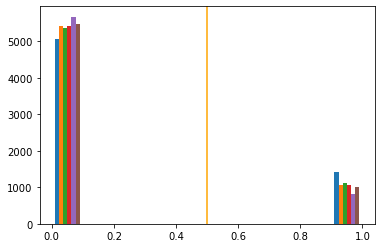

In [20]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [21]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


95.02779493514515

In [22]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [23]:
"{:0.2f}".format(pct_auc)

'97.02'

In [24]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [25]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [26]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [27]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_dense_2,n_dense_1,n_conv_3,n_conv_2,n_conv_1,maxpooling_pool_size,k_conv_3,k_conv_2,k_conv_1,dropout_2,dropout_1,avepooling_pool_size,activation_dense,activation_conv,mean,std
6,512,384,256,512,512,2,2,2,3,0.2,0.2,2,relu,relu,0.941504,0.003143
8,256,512,512,256,768,2,3,3,3,0.2,0.2,3,elu,relu,0.937730,0.003727
4,256,384,256,256,512,3,2,2,3,0.3,0.3,2,relu,relu,0.937095,0.002040
10,384,256,256,512,768,3,3,3,3,0.3,0.3,3,elu,relu,0.936717,0.001946
0,256,256,512,256,512,3,3,2,3,0.3,0.2,3,<tensorflow.python.keras.layers.advanced_activ...,relu,0.931466,0.002494
18,384,256,256,256,512,2,2,3,2,0.3,0.2,3,elu,relu,0.929733,0.002908
14,384,384,256,512,512,2,3,3,3,0.3,0.2,2,elu,elu,0.917379,0.003375
2,384,512,512,512,768,2,2,3,3,0.2,0.2,3,relu,<tensorflow.python.keras.layers.advanced_activ...,0.913569,0.001225
9,256,512,512,512,512,2,2,3,2,0.2,0.2,3,elu,elu,0.911579,0.002376
16,384,512,512,256,512,2,2,3,3,0.3,0.2,2,elu,elu,0.911253,0.006545


## Creating best model from the best param and train it for 60 epochs

In [43]:
rscv_results.best_params_

{'n_dense_2': 512,
 'n_dense_1': 384,
 'n_conv_3': 256,
 'n_conv_2': 512,
 'n_conv_1': 512,
 'maxpooling_pool_size': 2,
 'k_conv_3': 2,
 'k_conv_2': 2,
 'k_conv_1': 3,
 'dropout_2': 0.2,
 'dropout_1': 0.2,
 'avepooling_pool_size': 2,
 'activation_dense': 'relu',
 'activation_conv': 'relu'}

In [44]:
n_dense_2= 512
n_dense_1= 384
n_conv_3= 256
n_conv_2= 512
n_conv_1= 512
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
avepooling_pool_size= 2
activation_dense = 'relu'
activation_conv = 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [45]:
output_dir= 'model_ouput/tune-sklearn-3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [46]:
epochs = 120
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/120
228/228 [==============================] - 10s 42ms/step - loss: 0.9828 - accuracy: 0.5847 - val_loss: 0.7141 - val_accuracy: 0.7052
Epoch 2/120
228/228 [==============================] - 9s 41ms/step - loss: 0.6416 - accuracy: 0.7431 - val_loss: 0.5265 - val_accuracy: 0.8056
Epoch 3/120
228/228 [==============================] - 9s 41ms/step - loss: 0.4738 - accuracy: 0.8190 - val_loss: 0.3879 - val_accuracy: 0.8550
Epoch 4/120
228/228 [==============================] - 9s 41ms/step - loss: 0.3963 - accuracy: 0.8506 - val_loss: 0.3485 - val_accuracy: 0.8620
Epoch 5/120
228/228 [==============================] - 9s 41ms/step - loss: 0.3559 - accuracy: 0.8652 - val_loss: 0.3329 - val_accuracy: 0.8697
Epoch 6/120
228/228 [==============================] - 9s 41ms/step - loss: 0.3241 - accuracy: 0.8772 - val_loss: 0.3074 - val_accuracy: 0.8808
Epoch 7/120
228/228 [==============================] - 9s 41ms/step - loss: 0.3027 - accuracy: 0.8847 - val_loss: 0.3030 - val_accuracy

228/228 [==============================] - 9s 42ms/step - loss: 0.0504 - accuracy: 0.9819 - val_loss: 0.1626 - val_accuracy: 0.9643
Epoch 114/120
228/228 [==============================] - 9s 41ms/step - loss: 0.0529 - accuracy: 0.9798 - val_loss: 0.1727 - val_accuracy: 0.9631
Epoch 115/120
228/228 [==============================] - 9s 42ms/step - loss: 0.0565 - accuracy: 0.9803 - val_loss: 0.1599 - val_accuracy: 0.9629
Epoch 116/120
228/228 [==============================] - 9s 41ms/step - loss: 0.0503 - accuracy: 0.9816 - val_loss: 0.1755 - val_accuracy: 0.9625
Epoch 117/120
228/228 [==============================] - 9s 41ms/step - loss: 0.0541 - accuracy: 0.9799 - val_loss: 0.1614 - val_accuracy: 0.9611
Epoch 118/120
228/228 [==============================] - 9s 41ms/step - loss: 0.0504 - accuracy: 0.9815 - val_loss: 0.1752 - val_accuracy: 0.9619
Epoch 119/120
228/228 [==============================] - 9s 41ms/step - loss: 0.0502 - accuracy: 0.9817 - val_loss: 0.1696 - val_accuracy:

In [47]:
model.load_weights(output_dir+"/weights.113.hdf5") # 96.43

In [48]:
y_hat = model.predict(X_valid)

In [49]:
len(y_hat)

6476

In [50]:
y_hat[0]

array([6.3744292e-04, 1.9361429e-11, 3.9238501e-10, 3.7778257e-12,
       3.4377590e-06, 9.9935907e-01], dtype=float32)

In [51]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

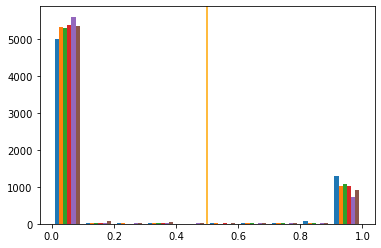

In [52]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [53]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'99.80'

In [54]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'96.34'

In [55]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [56]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [57]:
ydf.head(10)

,y_hat,y
0,"[0.001, 0.0, 0.0, 0.0, 0.0, 0.999]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 0.999, 0.001, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
